In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
# Load the roster data
roster = pd.read_csv('../final/roster.csv')
roster.head()

,last_name,first_name,middle_initial,gender,race,birthyear,age,status,appointment_date,position_no,...,star7,star8,star9,star10,star11,sworn,unit_id,unit_detail,star,uid
0,HANSEN,GRACIBEL,NaN,F,WHITE HISPANIC,1973.0,44.0,Y,2004-10-25,9161,...,NaN,NaN,NaN,NaN,NaN,Y,13.0,NaN,5512.0,2162b5ba-fd29-4474-8c70-455fb642bb1f
1,AARON,JEFFERY,M,M,WHITE,1971.0,46.0,Y,2005-09-26,9171,...,NaN,NaN,NaN,NaN,NaN,Y,21.0,NaN,1424.0,c251a31d-030f-40a0-900e-4dc7f6f86d51
2,AARON,KARINA,NaN,F,WHITE HISPANIC,1980.0,37.0,Y,2005-09-26,9165,...,NaN,NaN,NaN,NaN,NaN,Y,194.0,NaN,20373.0,f6aedb8d-3c01-4838-a3a9-b50cee054a1b
3,ABATE,DANIEL,P,M,WHITE,1942.0,75.0,N,1970-06-15,9161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549d5ddc-9e5a-4b12-9ab0-022c6dbca249
4,ABBATE,ANTHONY,G,M,WHITE,1968.0,48.0,N,1994-12-05,9161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cfae6371-0e9a-4382-b35c-19c52f2dfb4a


In [3]:
# Load the salary data
salary  = pd.read_csv('../final/salary.csv')
salary.head()

,uid,year,salary,position_description,pay_grade,present_posn_start_date,officer_date,employee_status
0,c251a31d-030f-40a0-900e-4dc7f6f86d51,2005,40830,POLICE OFFICER,D|1,2005-09-26,2005-09-26,PROBATIONARY CAREER SERVICE
1,c251a31d-030f-40a0-900e-4dc7f6f86d51,2006,54636,POLICE OFFICER,D|1,2005-09-26,2005-09-26,PROBATIONARY CAREER SERVICE
2,c251a31d-030f-40a0-900e-4dc7f6f86d51,2007,58896,POLICE OFFICER,D|1,2005-09-26,2005-09-26,CAREER SERVICE
3,c251a31d-030f-40a0-900e-4dc7f6f86d51,2008,61932,POLICE OFFICER,D|1,2005-09-26,2005-09-26,CAREER SERVICE
4,c251a31d-030f-40a0-900e-4dc7f6f86d51,2009,64992,POLICE OFFICER,D|1,2005-09-26,2005-09-26,CAREER SERVICE


In [4]:
# create a mapping of position shortnames
positions_short = {'POLICE OFFICER' : 'Officer', 
             'POLICE OFFICER (ASSIGNED AS DETECTIVE)' : 'Detective',
             'SERGEANT' : 'Sergeant', 
             'LIEUTENANT' : 'Lieutenant', 
             'CAPTAIN' : 'Captain', 
             'COMMANDER' : 'Commander', 
             'DEPUTY CHIEF' : 'Dep. Chief', 
             'CHIEF' : 'Chief',
             'DEPUTY SUPERINTENDENT' : 'Dep. Sup.', 
             'FIRST DEPUTY SUPERINTENDENT' : '1st Dep. Sup.'}

# create a map of shortnames of races
races_short = {'WHITE' : 'White', 
              'BLACK' : 'Black',
              'BLACK HISPANIC' : 'Bl. Hisp.',
              'WHITE HISPANIC' : 'Wh. Hisp.',
              'ASIAN/PACIFIC ISLANDER' : 'Asian/P.I.',
              'AMER IND/ALASKAN NATIVE' : 'Indig.',
              'Other' : 'Other'}

In [5]:
# build a map of UID -> (race, gender)
trait_map = {}
traits = ['race', 'gender']

for i in range(roster.shape[0]):
    trait_map[roster.uid.iloc[i]] = {tr : roster[tr].iloc[i] for tr in traits}

# for each trait, add a column to the awards data using the map
for tr in traits:
    salary[tr] = salary.uid.map(lambda x : trait_map[x][tr])
    
# in the below plots, Asian/Pacific Islander, Indigenous, and Black Hispanic categories are too small to visualize individually.
# group them into "Other"
salary.race = salary.race.map(lambda x : 'Other' if x in ['ASIAN/PACIFIC ISLANDER', 'AMER IND/ALASKAN NATIVE', 'BLACK HISPANIC'] else x)
       
salary

,uid,year,salary,position_description,pay_grade,present_posn_start_date,officer_date,employee_status,race,gender
0,c251a31d-030f-40a0-900e-4dc7f6f86d51,2005,40830,POLICE OFFICER,D|1,2005-09-26,2005-09-26,PROBATIONARY CAREER SERVICE,WHITE,M
1,c251a31d-030f-40a0-900e-4dc7f6f86d51,2006,54636,POLICE OFFICER,D|1,2005-09-26,2005-09-26,PROBATIONARY CAREER SERVICE,WHITE,M
2,c251a31d-030f-40a0-900e-4dc7f6f86d51,2007,58896,POLICE OFFICER,D|1,2005-09-26,2005-09-26,CAREER SERVICE,WHITE,M
3,c251a31d-030f-40a0-900e-4dc7f6f86d51,2008,61932,POLICE OFFICER,D|1,2005-09-26,2005-09-26,CAREER SERVICE,WHITE,M
4,c251a31d-030f-40a0-900e-4dc7f6f86d51,2009,64992,POLICE OFFICER,D|1,2005-09-26,2005-09-26,CAREER SERVICE,WHITE,M
...,...,...,...,...,...,...,...,...,...,...
193681,183e5650-4a39-49f6-88d8-9172dcd52cc2,2013,80724,POLICE OFFICER,D|1,1996-12-02,1996-12-02,CAREER SERVICE,WHITE,M
193682,183e5650-4a39-49f6-88d8-9172dcd52cc2,2014,85662,POLICE OFFICER,D|1,1996-12-02,1996-12-02,CAREER SERVICE,WHITE,M
193683,183e5650-4a39-49f6-88d8-9172dcd52cc2,2015,86520,POLICE OFFICER,D|1,1996-12-02,1996-12-02,CAREER SERVICE,WHITE,M
193684,183e5650-4a39-49f6-88d8-9172dcd52cc2,2016,92430,POLICE OFFICER,D|1,1996-12-02,1996-12-02,CAREER SERVICE,WHITE,M


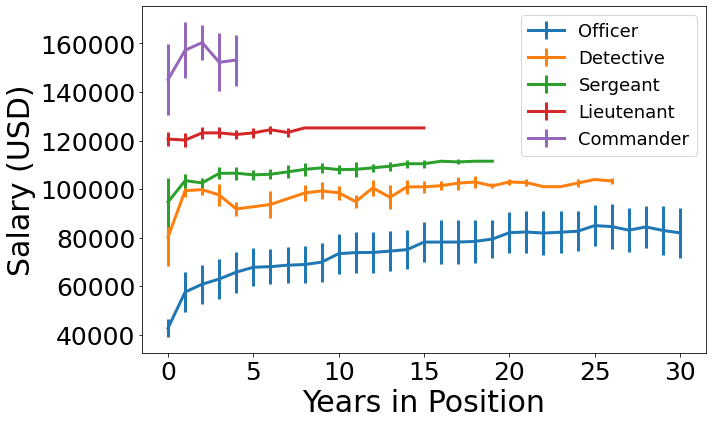

In [23]:
import warnings
warnings.filterwarnings('ignore')

# plot salary vs years in posn for these positions
positions = ['POLICE OFFICER', 'POLICE OFFICER (ASSIGNED AS DETECTIVE)', 'SERGEANT', 'LIEUTENANT', 'COMMANDER']

plt.figure(figsize = (10,6))
for posn in positions:
    # restrict to the particular position
    rows = salary[salary.position_description == posn]
    
    # compute the number of years the officer has spent in their current position for each record
    rows['posn_start_year'] = list(map(lambda x : x.year, pd.to_datetime(rows.present_posn_start_date.values)))
    rows['years_in_posn'] = rows['year'] - rows['posn_start_year']   

    # remove very old entries
    rows = rows[rows.years_in_posn <= 30]
    # aggregate and compute stats
    agg = rows.groupby('years_in_posn').salary.agg(['mean', 'std', 'count'])
    agg.reset_index(inplace=True)
    # only plot when there were a large enough group of officers (at least 3)
    agg = agg[agg['count'] >= 3]
    plt.errorbar(agg.index, agg['mean'], agg['std'], label=positions_short[posn], lw = 3)
plt.xlabel('Years in Position', fontsize = 30)
plt.ylabel('Salary (USD)', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.legend(fontsize = 18)
plt.tight_layout()
plt.savefig('../doc/figs/salary.pdf')
plt.show()

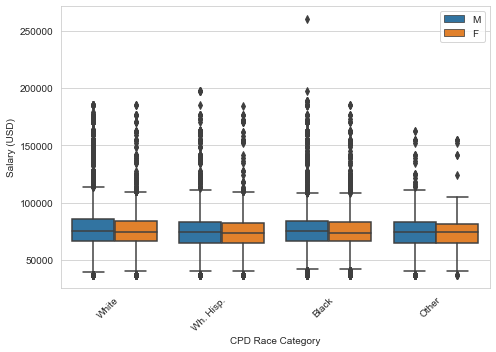

In [24]:
# plot salary all positions across race + gender
sns.set_style('whitegrid')
plt.figure(figsize = (7,5))
tmp = salary.race.copy()
salary.race = salary.race.map(races_short)
sns.boxplot(x='race', y='salary', hue='gender', data=salary)
salary.race = tmp
plt.xlabel('CPD Race Category')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.legend()
plt.tight_layout()
plt.savefig('../doc/figs/salary_by_race_gender.pdf')
plt.show()

In [25]:
# restrict to the above posns
salary = salary[salary.position_description.isin(positions_short.keys())]

# in the below plots, Lieutenant/Commander/Captain and (deputy) chief/superintendent get grouped
salary.position_description = salary.position_description.map(lambda x : 'Cpt/Cmd/Lt' if x in ['COMMANDER', 'LIEUTENANT', 'CAPTAIN'] else x)
salary.position_description = salary.position_description.map(lambda x : 'Chief/Super' if x in ['CHIEF', 'DEPUTY CHIEF', 'DEPUTY SUPERINTENDENT', 'FIRST DEPUTY SUPERINTENDENT'] else x)
positions_short['Cpt/Cmd/Lt'] = 'Cpt/Cmd/Lt'
positions_short['Chief/Super'] = 'Chief/Super'
plot_positions = ['POLICE OFFICER', 
                   'POLICE OFFICER (ASSIGNED AS DETECTIVE)',
                   'SERGEANT', 
                   'Cpt/Cmd/Lt', 
                   'Chief/Super']
    
#     
sal = salary.groupby(['gender', 'position_description']).agg(['count'])
sal.reset_index(inplace=True)
sal['count'] = sal['uid']['count']
# restrict the dataframe to just (gender, posn, count)
sal = sal[['gender', 'position_description', 'count']]

# fix tuple colnames
sal.columns = sal.columns.map(''.join)
# fill in missing rows with count = 0
for gender in sal.gender.unique():
    for posn in plot_positions:
        if sal[(sal.gender == gender) & (sal.position_description == posn)].shape[0] == 0:
            sal = sal.append({'gender' : gender, 'position_description' : posn, 'count' : 0}, ignore_index=True)

sal['frac'] = 0.
for posn in plot_positions:
    salp = sal[sal.position_description == posn]
    ct = salp['count'].sum()
    salp['frac'] = salp['count']/ct
    sal.loc[sal.position_description == posn, 'frac'] = salp['frac'].values

# sort by rank
sorter = dict(zip(plot_positions, range(len(plot_positions))))
sal['rank'] = sal['position_description'].map(sorter)
sal.sort_values(['rank'], ascending = [True], inplace = True)
sal.reset_index(inplace=True)
sal.drop('index', axis=1, inplace=True)

# rename some of the longer titles
sal.position_description = sal.position_description.map(positions_short)
sal

,gender,position_description,count,frac,rank
0,F,Officer,36229,0.242890,0
1,M,Officer,112929,0.757110,0
2,F,Detective,2981,0.193320,1
3,M,Detective,12439,0.806680,1
4,F,Sergeant,3403,0.182672,2
5,M,Sergeant,15226,0.817328,2
6,F,Cpt/Cmd/Lt,159,0.167017,3
7,M,Cpt/Cmd/Lt,793,0.832983,3
8,F,Chief/Super,50,0.140845,4
9,M,Chief/Super,305,0.859155,4


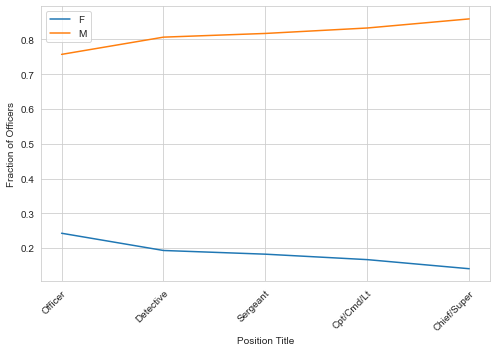

In [26]:
plt.figure(figsize = (7,5))
plt.plot(sal[sal.gender == 'F'].position_description, sal[sal.gender=='F'].frac, label='F')
plt.plot(sal[sal.gender == 'M'].position_description, sal[sal.gender=='M'].frac, label='M')
plt.legend(loc='upper left')
plt.xlabel('Position Title')
plt.ylabel('Fraction of Officers')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.tight_layout()
plt.savefig('../doc/figs/position_gender.pdf')
plt.show()

In [27]:
sal = salary.groupby(['race', 'position_description']).agg(['count'])
sal.reset_index(inplace=True)
sal['count'] = sal['uid']['count']
# restrict the dataframe to just (race, gender, count)
sal = sal[['race', 'position_description', 'count']]
# restrict to the above posns
sal = sal[sal.position_description.isin(plot_positions)]
# fix tuple colnames
sal.columns = sal.columns.map(''.join)
# fill in missing rows with count = 0
for race in sal.race.unique():
    for posn in plot_positions:
        if sal[(sal.race == race) & (sal.position_description == posn)].shape[0] == 0:
            sal = sal.append({'race' : race, 'position_description' : posn, 'count' : 0}, ignore_index=True)

sal['frac'] = 0.
for posn in positions_short.keys():
    salp = sal[sal.position_description == posn]
    ct = salp['count'].sum()
    salp['frac'] = salp['count']/ct
    sal.loc[sal.position_description == posn, 'frac'] = salp['frac'].values
   
# sort by rank
sorter = dict(zip(plot_positions, range(len(plot_positions))))
sal['rank'] = sal['position_description'].map(sorter)
sal.sort_values(['rank'], ascending = [True], inplace = True)
sal.reset_index(inplace=True)
sal.drop('index', axis=1, inplace=True)

# rename some of the longer titles
sal.position_description = sal.position_description.map(positions_short)
sal

,race,position_description,count,frac,rank
0,WHITE HISPANIC,Officer,31203,0.209332,0
1,BLACK,Officer,39104,0.262337,0
2,Other,Officer,4390,0.029451,0
3,WHITE,Officer,74363,0.498880,0
4,WHITE HISPANIC,Detective,2138,0.138651,1
5,BLACK,Detective,2685,0.174125,1
6,WHITE,Detective,10264,0.665629,1
7,Other,Detective,333,0.021595,1
8,WHITE,Sergeant,12990,0.697300,2
9,Other,Sergeant,310,0.016641,2


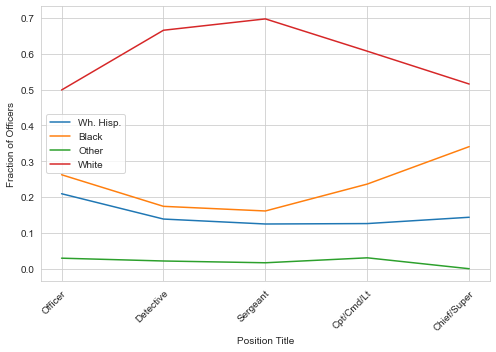

In [28]:
plt.figure(figsize = (7,5))
for race in sal.race.unique():
    plt.plot(sal[sal.race == race].position_description, sal[sal.race == race].frac, label=races_short[race])
plt.legend(loc='center left')
plt.xlabel('Position Title')
plt.ylabel('Fraction of Officers')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.tight_layout()
plt.savefig('../doc/figs/position_race.pdf')
plt.show()